In [1]:
import cv2, glob, imutils, sys, os, csv
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn import svm
from sklearn.model_selection import train_test_split
from skimage.feature import greycomatrix, greycoprops

In [2]:
path_images = []
base_path = 'C:/Users/PC/Desktop/S3/imagemining/Atelier2/DB2C/'
with os.scandir(base_path) as listdir:
    for lis in listdir:
        if lis.is_dir():
            for file in os.scandir(base_path+lis.name):
                full_link = base_path+lis.name+'/'+file.name
                path_images.append( (full_link ,lis.name))

In [3]:
base_path = 'C:/Users/PC/Desktop/S3/imagemining/Atelier2/DataToPredict/'
data_test =[]
with os.scandir(base_path) as listdir:
    for lis in listdir:
        data_test.append(base_path+lis.name)

In [4]:
def getColorMoments(img):
    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
    feature = [np.mean(R), np.std(R), np.mean(G), np.std(G), np.mean(B), np.std(B)]
    return feature/np.mean(feature) 


def getTextureFeatures(img):
    glcm     = greycomatrix(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY), [1], [0] ,symmetric=True, normed=True)
    contrast = greycoprops(glcm, 'contrast')
    corre    = greycoprops(glcm , 'correlation')
    energy   = greycoprops(glcm , 'energy')
    Homogeneity   = greycoprops(glcm , 'homogeneity')
    texture_features = [contrast[0][0],corre[0][0],energy[0][0],Homogeneity[0][0] ]
    texture_features =  texture_features / sum(texture_features)
    return texture_features

def extract_color_histogram(image, bins=(8, 8, 8)):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,[0, 180, 0, 256, 0, 256])

    if imutils.is_cv2():
        hist = cv2.normalize(hist)
    else:
        cv2.normalize(hist, hist) 
    return hist.flatten()

def getShapeFeatures(img):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    shapeFeat = cv2.HuMoments(cv2.moments(image)).flatten()
    shapeFeat= shapeFeat / np.mean(shapeFeat)
    return shapeFeat

def getFeatures(img):
    cm = getColorMoments(img)
    ch = extract_color_histogram(img)
    tx = getTextureFeatures(img)
    shape = getShapeFeatures(img)
    features = np.append(cm, ch, axis=None)
    nv = np.append(features ,shape , axis =None)
    return np.append(nv ,tx ,axis = None)

In [5]:
def apprentissage(path_images):
    features = []
    labels   = []
    for image,label in path_images:
        img = cv2.imread(image)
        feature = getFeatures(img)
        features.append(feature)
        labels.append(label)
        
    features = np.array(features)
    labels   = np.array(labels)
    
    (trainFeat, testFeat, trainLabels, testLabels) = train_test_split(
            features, labels, test_size=0.25, random_state=random.seed())
    
    model = svm.SVC(gamma=0.1, C=100)
    model.fit(trainFeat,trainLabels)
    
    print("précision :", model.score(testFeat,testLabels))
    return model
    

précision : 0.959349593495935


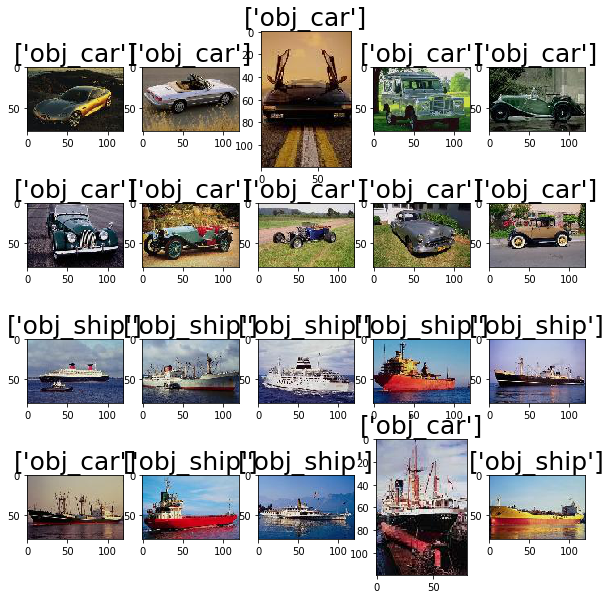

In [6]:
model = apprentissage(path_images)
list_predict = []
list_label   = []

toSaveinCsv = []

count = 0
for image1 in data_test:
    image = cv2.imread(image1)
    feaut = getFeatures(image)
    list_predict.append(model.predict([feaut]))
    toSaveinCsv.append( ( image1.replace("C:/Users/PC/Desktop/S3/imagemining/Atelier2/DataToPredict/",""),model.predict([feaut])  )  )
    if count < 10:
        list_label.append('obj_car')
    else:
        list_label.append('obj_ship')
    count+=1
    

    
with open('Prediction_corelDB_laazabderrahim.csv', 'w', newline='') as file:
    fieldnames = ['Name', 'Class']
    writer = csv.DictWriter(file, fieldnames=fieldnames)

    writer.writeheader()
    for name,classObj in toSaveinCsv:
        writer.writerow({'Name': name, 'Class': classObj[0]})
   
    
    
fig, axes = plt.subplots(4, 5, figsize = (10,10))
axes = axes.ravel()

for i in np.arange(0, 20): 
    axes[i].imshow(plt.imread(data_test[i]))
    axes[i].set_title(list_predict[i], fontsize = 25)

plt.subplots_adjust(hspace=0)

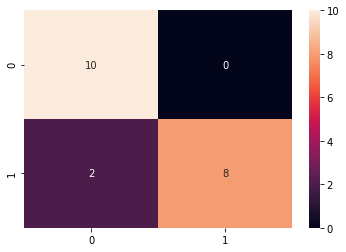

In [7]:
from sklearn.svm import SVC 
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
cm = confusion_matrix(list_label, list_predict)
sns.heatmap(cm, annot=True)